## Transfer Learning 을 이용한 aespa 그룹의 멤버 Winter, karina, ningning Classifier 생성
  1. 이미지 크롤링
  2. Transfer Learning
  3. 웹 API 개발

한글 폰트 설치 이후에 [런타임] - [런타임 다시 시작]을 수행해야 합니다.

In [ ]:
# 한글폰트 : 네이버 바른 고딕 설정 by. 송인표 / 22.05.07
!apt install fonts-nanum -y

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)
plt.rc('font', family='NanumBarunGothic')
matplotlib.font_manager._rebuild()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 42 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (17.9 MB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 155203 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

my_path = '/content/notebooks'
os.symlink('/content/drive/MyDrive/Colab Notebooks/my_env', my_path)
sys.path.insert(0, my_path)

Mounted at /content/drive


# 1. 구글 이미지 크롤러를 이용한 학습 이미지 수집

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
from tqdm import tqdm
import urllib.request
import shutil

In [ ]:
# 구글 이미지 크롤링을 위한 드라이버 설치
  # 이 부분은 처음 한번만 실행하면 됌.

!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [742 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [85.2 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bioni

In [ ]:
directory_list = [
    '/content/drive/MyDrive/Human_classification/custom_dataset/train/',
    '/content/drive/MyDrive/Human_classification/custom_dataset/val/',
    '/content/drive/MyDrive/Human_classification/custom_dataset/test/',
]

# 초기 디렉토리 만들기
for directory in directory_list:
    if not os.path.isdir(directory):
      # os.path.isdir(path) 는 path가 존재하는 디렉토리이면 True 반환
      # os.path.isfile(path) 는 path가 존재하는 파일이면 True 반환
        os.makedirs(directory)

# 수집한 이미지를 학습 데이터와 평가 데이터로 구분하는 함수
def dataset_split(idol, train_cnt, val_cnt):
    # 학습 및 평가 데이터셋 디렉토리 만들기
    for directory in directory_list:
        if not os.path.isdir(directory + '/' + idol):
            try:
                os.makedirs(directory + '/' + idol)
            except:
                print("error")
    # 학습 및 평가 데이터셋 준비하기
    cnt = 1
    for file_name in os.listdir('/content/drive/MyDrive/Human_classification/'+idol):
        if cnt < val_cnt:
            print(f'[Validation Dataset] {file_name}')
            shutil.move('/content/drive/MyDrive/Human_classification/'+ idol + '/' + file_name, '/content/drive/MyDrive/Human_classification/custom_dataset/val/' + idol + '/' + file_name)
        elif cnt < train_cnt:
            print(f'[Train Dataset] {file_name}')
            shutil.move('/content/drive/MyDrive/Human_classification/'+ idol + '/' + file_name, '/content/drive/MyDrive/Human_classification/custom_dataset/train/' + idol + '/' + file_name)
        else:
            print(f'[Test Dataset] {file_name}')
            shutil.move('/content/drive/MyDrive/Human_classification/'+ idol + '/' + file_name, '/content/drive/MyDrive/Human_classification/custom_dataset/test/' + idol + '/' + file_name)
        cnt += 1
    shutil.rmtree('/content/drive/MyDrive/Human_classification/'+idol) # 지정된 파일 및 하위 디렉토리 전부 삭제

In [ ]:
def createDirectory(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print("Error: Failed to create the directory.")

In [ ]:
def crawling_img(name):
    options = webdriver.ChromeOptions()
    options.add_argument('--headless')        # Head-less 설정
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')
    driver = webdriver.Chrome('chromedriver', options=options)
    # 해당 url로 이동
    url = "https://www.google.co.kr/imghp?hl=ko&ogbl"
    driver.get(url)

    # 검색창을 찾는 코드
    # 내가 원하는 요소를 클릭하거나 하는 거 찾을 때는 F12를 눌러 왼쪽 위 마우스로
    # 찾는 기능을 이용해서 class, name 을 확인한다.

    elem = driver.find_element_by_name("q")
      # name으로 찾는 방법 외에도, class 등 다른 방법도 사용 가능하다.
      # elem = driver.find_element_by_class("gLFyf gsfi")

    # 원하는 입력값 전송 - 원하는 검색어 검색
    elem.send_keys(name)
    elem.send_keys(Keys.RETURN) # 엔터키 입력

    # 검색 후에 스크롤을 끝까지 다 내려서 일단 다 불러온다.
    SCROLL_PAUSE_TIME = 1

    # 브라우저의 높이를 알아내서 last_height에 저장한다.
    last_height = driver.execute_script("return document.body.scrollHeight")

    # 무한반복문
    while True:
        # Scroll down to bottom
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

        # Wait to load page
        time.sleep(SCROLL_PAUSE_TIME)

        # 새로운 높이가 이전의 높이와 같다면 빠져나온다. 즉, 더이상 안내려가면
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            try:
                driver.find_element_by_css_selector(".mye4qd").click() # 결과더보기 누름
            except:
                break # 결과더보기 없으면 이제 무한반복을 멈춘다.
        last_height = new_height

    # 작은 이미지 클릭
    images = driver.find_elements_by_css_selector(".rg_i.Q4LuWd")
      # 여러개의 요소를 리스트 해야하므로 elements 사용
      # css의 특성상 클래스의 띄어쓰기에 . 을 대신해서 넣는다.
      # [0].click() 은 가장 첫번째 요소를 끄집어내서 클릭하겠다는 의미

    # Create directory
    dir = "/content/drive/MyDrive/Human_classification/" + name
    createDirectory(dir)

    count = 1
    for image in images:
        try:
          image.click()
          time.sleep(2)
          # 큰 이미지 선택하여 이미지 다운할 수 있는 src 주소 받아오기
          imgUrl = driver.find_element_by_xpath('/html/body/div[3]/c-wiz/div[3]/div[2]/div[3]/div/div/div[3]/div[2]/c-wiz/div/div[1]/div[1]/div[3]/div/a/img').get_attribute("src")
          # imgUrl = driver.find_element_by_css_selector(".n3VNCb").get_attribute("src")

          # path = '/content/drive/MyDrive/Human_classification/' + name

          urllib.request.urlretrieve(imgUrl, dir + '/' + str(count) + ".jpg")
          # count는 숫자형이기 때문에 str로 string형으로 만들어 문자끼리 더해지게 한다.
          count = count + 1
          if count >= 300:
              break
        except:
            pass
      
    driver.close()

In [ ]:
idol = '에스파 윈터'
crawling_img(idol)
dataset_split(idol, 270, 30)

In [ ]:
idol = '에스파 카리나'
crawling_img(idol)
dataset_split(idol, 270, 30)

In [ ]:
idol = '에스파 닝닝'
crawling_img(idol)
dataset_split(idol, 270, 30)

#2. Transfer Learning

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import time

# colab에서 GPU사용 by. 송인표 / 22.05.07

# use_cuda = True
# if use_cuda and torch.cuda.is_available():
#     net.cuda()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device 객체

데이터 가공

In [ ]:
# 데이터셋을 불러올 때 사용할 변형(transformation) 객체 정의

# transforms.Normalize([meanR, meanG, meanB], [stdR, stdG, stdB])
# transform.Normalize([R 평균, G 평균, B 평균], [R 표준편차, G 표준편차, B 표준편차])
# ImageNet과 유사할 경우 그 평균과 표준편차를 사용한다. [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # 데이터 증진(augmentation)
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
])

transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = '/content/drive/MyDrive/Human_classification/custom_dataset'
train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
val_datasets = datasets.ImageFolder(os.path.join(data_dir, 'val'), transforms_val)
test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=4, shuffle=True, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(val_datasets, batch_size=4, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=4, shuffle=True, num_workers=4)

print('train 데이터셋 크기:', len(train_datasets))
print('val 데이터셋 크기:', len(val_datasets))
print('test 데이터셋 크기:', len(test_datasets))

class_names = train_datasets.classes
print('클래스:', class_names)

train 데이터셋 크기: 713
val 데이터셋 크기: 87
test 데이터셋 크기: 90
클래스: ['에스파 닝닝', '에스파 윈터', '에스파 카리나']


/content/notebooks/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


이미지 불러보기

/content/notebooks/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4363 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4454 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4361 missing from current font.
  font.s

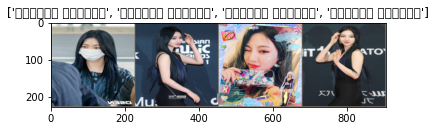

In [ ]:
def imshow(input, title):
    # torch.Tensor를 numpy 객체로 변환
    input = input.numpy().transpose((1, 2, 0))
    # 이미지 정규화 해제하기
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # 이미지 출력
    plt.imshow(input)
    plt.title(title)
    plt.show()


# 학습 데이터를 배치 단위로 불러오기
iterator = iter(train_dataloader)

# 현재 배치를 이용해 격자 형태의 이미지를 만들어 시각화
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

Transfer Learning - Last layer train

In [ ]:
model = models.resnet34(pretrained=True)
num_features = model.fc.in_features
# 전이 학습(transfer learning): 모델의 출력 뉴런 수를 3개로 교체하여 마지막 레이어 다시 학습
model.fc = nn.Linear(num_features, 3)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Train

In [ ]:
num_epochs = 50
model.train()
start_time = time.time()

# 전체 반복(epoch) 수 만큼 반복하며
for epoch in range(num_epochs):
    running_loss = 0.
    running_corrects = 0

    # 배치 단위로 학습 데이터 불러오기
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 모델에 입력(forward)하고 결과 계산
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_datasets)
    epoch_acc = running_corrects / len(train_datasets) * 100.

    # 학습 과정 중에 결과 출력
    print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

/content/notebooks/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#0 Loss: 1.1910 Acc: 44.4600% Time: 35.8304s
#1 Loss: 0.9976 Acc: 60.8696% Time: 61.7466s
#2 Loss: 0.8052 Acc: 69.7055% Time: 87.6448s
#3 Loss: 0.7140 Acc: 72.6508% Time: 113.7694s
#4 Loss: 0.7740 Acc: 72.2300% Time: 139.7566s
#5 Loss: 0.7235 Acc: 74.6143% Time: 166.0925s
#6 Loss: 0.4557 Acc: 82.8892% Time: 191.8777s
#7 Loss: 0.5509 Acc: 80.7854% Time: 217.6845s
#8 Loss: 0.4128 Acc: 85.5540% Time: 243.6814s
#9 Loss: 0.4171 Acc: 86.3955% Time: 269.5482s
#10 Loss: 0.3561 Acc: 88.6395% Time: 295.4909s
#11 Loss: 0.3188 Acc: 87.9383% Time: 321.3732s
#12 Loss: 0.3564 Acc: 88.2188% Time: 347.4681s
#13 Loss: 0.2457 Acc: 92.1459% Time: 373.3792s
#14 Loss: 0.2414 Acc: 93.6886% Time: 399.2753s
#15 Loss: 0.1490 Acc: 95.6522% Time: 425.3947s
#16 Loss: 0.1321 Acc: 95.0912% Time: 451.4373s
#17 Loss: 0.2121 Acc: 94.1094% Time: 477.5659s
#18 Loss: 0.1987 Acc: 92.9874% Time: 503.6101s
#19 Loss: 0.2528 Acc: 92.2861% Time: 529.6670s
#20 Loss: 0.1560 Acc: 95.6522% Time: 555.8120s
#21 Loss: 0.1599 Acc: 95.9

In [ ]:
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for inputs, labels in val_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # 한 배치의 첫 번째 이미지에 대하여 결과 시각화
        print(f'[예측 결과: {class_names[preds[0]]}] (실제 정답: {class_names[labels.data[0]]})')
        imshow(inputs.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

    epoch_loss = running_loss / len(val_datasets)
    epoch_acc = running_corrects / len(val_datasets) * 100.
    print('[Val Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))

Output hidden; open in https://colab.research.google.com to view.

Test

In [ ]:
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # 한 배치의 첫 번째 이미지에 대하여 결과 시각화
        print(f'[예측 결과: {class_names[preds[0]]}] (실제 정답: {class_names[labels.data[0]]})')
        imshow(inputs.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

    epoch_loss = running_loss / len(test_datasets)
    epoch_acc = running_corrects / len(test_datasets) * 100.
    print('[Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))

Output hidden; open in https://colab.research.google.com to view.

Classifier Model API
  - 한 장의 이미지를 불러와 결과를 반환하는 API

In [ ]:
# 원하는 경로에 테스트용 이미지 다운로드하기
# !wget -0 path url
!wget -O /content/drive/MyDrive/Human_classification/custom_dataset/test_image.jpg https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSK4bCHWogTfQIH6BWB42CD1_cvt1iW4fxuqA&usqp=CAU

--2022-05-07 19:07:12--  https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSK4bCHWogTfQIH6BWB42CD1_cvt1iW4fxuqA
Resolving encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)... 142.251.111.139, 142.251.111.138, 142.251.111.113, ...
Connecting to encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)|142.251.111.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8225 (8.0K) [image/jpeg]
Saving to: ‘/content/drive/MyDrive/Human_classification/custom_dataset/test_image.jpg’

/content/drive/MyDr 100%[===================>]   8.03K  --.-KB/s    in 0.001s  

2022-05-07 19:07:12 (12.2 MB/s) - ‘/content/drive/MyDrive/Human_classification/custom_dataset/test_image.jpg’ saved [8225/8225]



/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4363 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4454 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4361 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4467 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4369 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4449 missing from current font.
  font.set_text(s

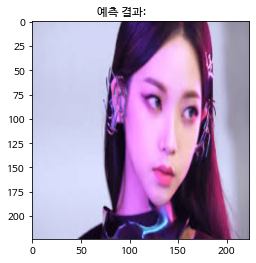

In [ ]:
from PIL import Image


image = Image.open('/content/drive/MyDrive/Human_classification/custom_dataset/test_image.jpg')
image = transforms_test(image).unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(image)
    _, preds = torch.max(outputs, 1)
    imshow(image.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

In [ ]:
!pip install flask-ngrok

import io
from flask_ngrok import run_with_ngrok
from flask import Flask, jsonify, request


# 이미지를 읽어 결과를 반환하는 함수
def get_prediction(image_bytes):
    image = Image.open(io.BytesIO(image_bytes))
    image = transforms_test(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
        imshow(image.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

    return class_names[preds[0]]


app = Flask(__name__)


@app.route('/', methods=['POST'])
def predict():
    if request.method == 'POST':
        # 이미지 바이트 데이터 받아오기
        file = request.files['file']
        image_bytes = file.read()

        # 분류 결과 확인 및 클라이언트에게 결과 반환
        class_name = get_prediction(image_bytes=image_bytes)
        print("결과:", {'class_name': class_name})
        return jsonify({'class_name': class_name})

API를 개방할 수 있으며 실행할 때마다 서버의 주소가 변경됩니다.

서버 주소를 정확히 확인할 필요가 있습니다.

나온 링크에 접속해서

In [ ]:
run_with_ngrok(app)
app.run()

명령프로프톰을 열고 cd path 명령어를 통해 이미지가 있는 디렉토리 호출

* 클라이언트 테스트 방법

<pre>
curl -X POST -F file=@{이미지 파일명} {Ngrok 서버 주소}
</pre>

* 사용 예시

<pre>
curl -X POST -F file=@dongseok.jpg http://c4cdb8de3a35.ngrok.io/
</pre>

* 이러한 방식으로 웹, 모바일, 게임 등의 소프트웨어 환경에서 API를 호출하는 방식으로 인공지능 앱을 개발할 수 있습니다.